In [1]:
import sys
sys.path.insert(0, '../src')

from megs.model.mPCA import mPCA
from megs.data import image, DataLoader, Galaxy

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

import numpy as np
import pickle
from tqdm import trange
import seaborn as sns
sns.set_context("paper", font_scale=1.5)

# Load mm object from the file
#filename = "morphmodel.pkl"
#filename = "2dmorphmodel400.pkl"
#with open(filename, "rb") as file:


#    mm = pickle.load(file)

In [2]:
data = DataLoader("/export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5", m_min = 8)


File: /export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5
Group: Galaxies
    Group: Attributes
        Dataset: halo_id (float32) ((12484,))
        Dataset: mass (float32) ((12484,))
    Group: Particles
        Group: stars
            Group: Images
                Group: dim2
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64))
                Group: dim3
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64, 64))


In [3]:
norm = image.norm # Normalization function
lower = 0.25
upper = 1.0
norm_function_args = {"Masses": {"takelog": True, "plusone": True,"lower": lower, "upper": upper},
                     "GFM_Metallicity": {"takelog": True, "plusone": True, "lower": 0.25, "upper": upper},
                     "GFM_StellarFormationTime": {"takelog": True, "plusone": True, "lower": 0.25, "upper": upper},
                    
}


In [4]:
mm = mPCA(data, norm_function = norm, norm_function_kwargs=norm_function_args, dim = 2)

Creating datamatrix with the following fields:
Particle type:  stars
Fields:  ['GFM_Metallicity', 'GFM_StellarFormationTime', 'Masses']
Dimension:  dim2
Default arguments are used for the fields that are not specified in the norm_function_kwargs
Created datamatrix with shape:  (12484, 12288)


In [5]:
mm.fit(n_components = 60,show_results = False)

In [6]:
original = mm.get_images()
eigengalaxies = mm.get_eigengalaxies()
means = mm.get_means()
scores = mm.scores
pca_projection = mm.inverse_transformed_datamatrix.reshape(original.shape)

In [ ]:
FIELDS = ["Metallicity", "Stellar Age", "Masses"]
CMAPS = {"Metallicity": "magma", "Stellar Age": "gist_heat", "Masses": "cividis"}

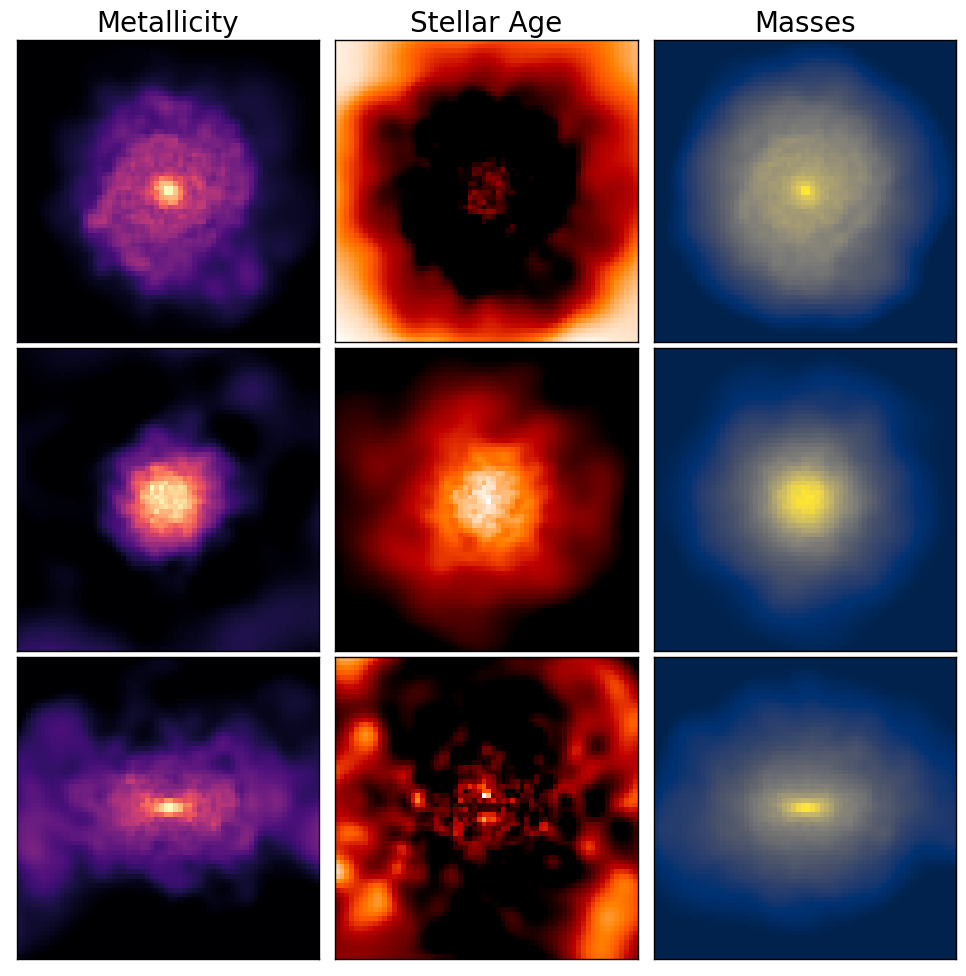

In [13]:
# Set up the figure and subplots
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Generate random indices for selecting images
#random_indices = np.random.choice(len(original), size=3, replace=False)
random_indices = [5794,7581,17]
random_samples = original[random_indices]

fields = ["Metallicity", "Stellar Age","Masses"]
cmaps = ["magma", "gist_heat","cividis"]
font_size = 20
# Iterate over the grid
for i in range(3):
    for j in range(3):
        # Get the random index
        # Plot the original image
        axs[i, j].imshow(random_samples[i, j], cmap=cmaps[j])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        if i == 0:
            axs[i, j].set_title(fields[j], fontsize=font_size)
        

# Adjust the spacing between subplots
plt.tight_layout(w_pad=0.0, h_pad=0.0)

# plt.savefig("sample_galaxies.pdf", bbox_inches='tight')
# Show the grid image
plt.show()


In [ ]:

gal3d_mass = [norm(data.get_image("stars","Masses",random_indices[i],dim = 3), **norm_function_args["Masses"]) for i in range(3)]
gal3d_age = [norm(data.get_image("stars","GFM_StellarFormationTime",random_indices[i],dim = 3), **norm_function_args["GFM_StellarFormationTime"]) for i in range(3)]
gal3d_metal = [norm(data.get_image("stars","GFM_Metallicity",random_indices[i],dim = 3), **norm_function_args["GFM_Metallicity"]) for i in range(3)]



In [ ]:
#Read pickle file
with open("galaxy_mPCA.pkl", "rb") as file:
        dat3d = pickle.load(file)
        


In [ ]:
dat3d["eigengalaxies"].shape

In [ ]:
dat3d["pca"].explained_variance_ratio_[:60].sum()

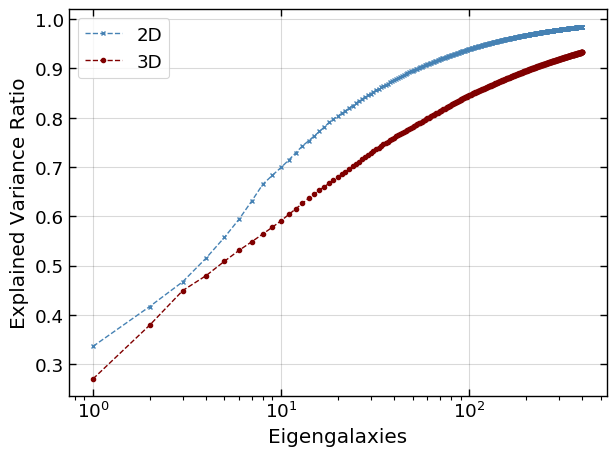

In [34]:
evr_2d_cumsum = np.cumsum(mm.pca.explained_variance_ratio_)
evr_3d_cumsum = np.cumsum(dat3d["pca"].explained_variance_ratio_)



# plt.figure(figsize=(8,6))
plt.plot(np.arange(1,len(mm.pca.components_)+1), evr_2d_cumsum, marker="x", color="steelblue", linestyle="dashed", linewidth=1, markersize=3,label = "2D")
plt.plot(np.arange(1,len(mm.pca.components_)+1), evr_3d_cumsum, marker="o", color="maroon", linestyle="dashed", linewidth=1, markersize=3,label = "3D")
plt.xlabel("Eigengalaxies")
plt.ylabel("Explained Variance Ratio")
plt.grid()
plt.tick_params(bottom=True, top=True, left=True, right=True, direction='in', which='major', grid_color='black', grid_alpha=0.15)
plt.xscale("log")
plt.legend()
plt.tight_layout()
plt.savefig("plots/evr_2d_and_3d.pdf", dpi=300)

In [ ]:
#Save as numpy
gal = np.array([gal3d_mass,gal3d_age,gal3d_metal])
np.save("galaxies.npy",gal)

In [ ]:
import plotly.graph_objects as go
def volume(hist ,opacity = .1, isomin = None, isomax = None, surface_count = 30, add_small_number = True, norm_hist = True, cmap = "gray",**kwargs):
    '''Visualise a 3D histogram as a volume.
    
    Uses plotly to visualise a 3D histogram as a volume. The volume can be normalised and a small number can be added to the histogram to avoid visualising empty space.
    
    Parameters
    ----------
    hist : numpy.array
        The 3D histogram to visualise.
    opacity : float, optional
        The opacity of the volume. The default is .1.
    isomin : float, optional
        The minimum value of the volume. The default is 0.
    isomax : float, optional
        The maximum value of the volume. The default is None.
    surface_count : int, optional
        The number of surfaces to use for the volume. The default is 30.
    add_small_number : bool, optional
        Whether to add a small number to the histogram to avoid visualizing empty space. The default is True.
    norm_hist : bool, optional
        Whether to normalise the histogram. The default is True.
    **kwargs :
        Additional arguments to pass to the normalisation function.
    '''
    if isomin is None: isomin = hist.min()
    if isomax is None: isomax = hist.max()
    data_hist =hist.copy()
    
    if norm_hist == True:
        data_hist = norm(data_hist, **kwargs)
    if add_small_number == True:
        #data_hist += 1e-10
        data_hist[data_hist == 0] = 1e-13
    xx, yy, zz = np.where(data_hist != 0)
    s = data_hist[xx,yy,zz]
    fig = go.Figure(data=go.Volume(
        x=xx,
        y=yy,
        z=zz,
        value=s,
        isomin=isomin,
        isomax=isomax,
        opacity=opacity, # needs to be small to see through all surfaces
        surface_count=surface_count,# needs to be a large number for good volume rendering
        colorscale= cmap
        ))
    fig.update_layout(scene_xaxis_showticklabels=False,
                  scene_yaxis_showticklabels=False,
                  scene_zaxis_showticklabels=False)
    
    fig.show()

In [ ]:
# Create 1000 PCA fits with random subsamples of the data
from tqdm import trange
from sklearn.decomposition import PCA
data = original.reshape(original.shape[0], -1).copy()
pca = PCA(n_components = 60)
explained_variance_ratio=[]
for i in trange(400):
    random_samples = np.random.choice(data.shape[0], int(data.shape[0]*0.75), replace=False)
    subsample = data[random_samples]
    pca.fit(subsample)
    explained_variance_ratio.append(pca.explained_variance_ratio_)
evr = np.array(explained_variance_ratio)
np.save("explained_variance_ratios_60_comp.npy",evr)

In [4]:
evr = np.load("explained_variance_ratios_60_comp.npy")

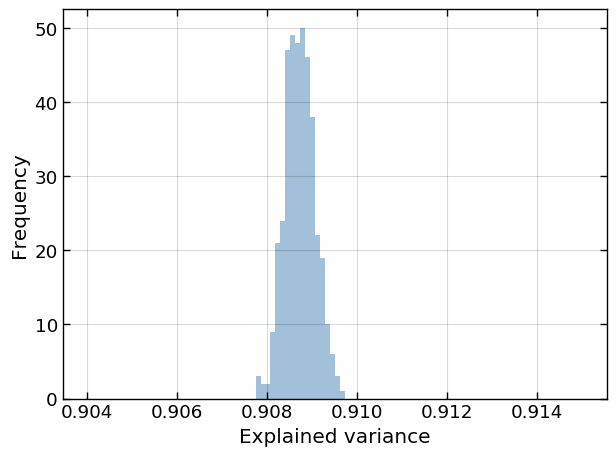

In [13]:
evr_sum = evr.sum(axis=1)
n_bins = 100
tick_range = (0.904,0.915)
plt.hist(evr_sum, bins=n_bins, color="steelblue", alpha=0.5, range = tick_range)
plt.xlabel("Explained variance")
plt.ylabel("Frequency")
plt.grid()
plt.tick_params(bottom=True, top=True, left=True, right=True, direction='in', which='major', grid_color='black', grid_alpha=0.15)
#Adjust tick label font size
#tickrange = np.linspace(tick_range, n_bins//2+1)
#plt.xticks(tickrange, ["{:.4f}".format(tick) for tick in tickrange], rotation=45)
plt.tight_layout()
import os 
os.makedirs("plots", exist_ok=True)

plt.savefig("plots/explained_variance_60_comp.png", dpi=300)

In [14]:
def reconstruct_single(galindex, n_components, original=original, scores=scores, eigen=eigengalaxies, means=means, plot=True, cmap=None, 
                savepath = None, show = True, labelsize=20,w_pad = 0.1,h_pad = 0.1, text_coords=(-32,32)):
    og = original[galindex]
    score = scores[galindex][:n_components]
    eig = eigen[:n_components]

    eig = eig.reshape(n_components, 3 * 64 ** 2)
    means = means.reshape(3 * 64 ** 2)
    reconstructed = np.dot(score, eig) + means
    reconstructed = reconstructed.reshape(3, 64, 64)
    residue = og - reconstructed.reshape(3, 64, 64)

    # Calculate the range for the residue images
    residue_min = np.min(residue)
    residue_max = np.max(residue)
    fields = ["Metallicity", "Stellar Age", "Masses"]
    if cmap is None:
        cmap = {"Metallicity": "magma", "Stellar Age": "gist_heat", "Masses": "cividis"}
    if plot:
        fig = plt.figure(figsize=(15, 15))
        gs = GridSpec(3, 4, width_ratios=[1, 1, 1, 0.1])  # Adjust width ratios to accommodate the colorbar

        for i in range(3):
            ax1 = fig.add_subplot(gs[i, 0])
            ax1.imshow(og[i], cmap=cmap[fields[i]])
            ax1.text(*text_coords, fields[i], fontsize=labelsize, verticalalignment='center', horizontalalignment='left')
            ax1.axis("off")

            ax2 = fig.add_subplot(gs[i, 1])
            ax2.imshow(reconstructed[i], cmap=cmap[fields[i]])
          
                
            ax2.axis("off")

            ax3 = fig.add_subplot(gs[i, 2])
            im = ax3.imshow(residue[i], cmap="coolwarm", vmin=residue_min, vmax=residue_max)
            
            if i==0: 
                ax1.set_title(f"Original",fontsize=labelsize)
                ax2.set_title(f"Reconstructed", fontsize=labelsize)
                ax3.set_title(f"Residue", fontsize=labelsize)
            
            ax3.axis("off")

        # Add a single colorbar on the right side
        cax = fig.add_subplot(gs[:, 3])
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label("Residue", fontsize=labelsize)

        plt.tight_layout(w_pad=w_pad,h_pad=h_pad)
        
        if savepath is not None:
            plt.savefig(savepath, dpi=300)
        if show: plt.show()

    return reconstructed, og

#Calcualte sse 
def sse(reconstructed, original):
    diff = np.sum((original - reconstructed) ** 2)
    sse = diff/np.sum(original)
    return sse
def calc_rec_error(number_of_components):
    return np.array([sse(reconstruct(i,number_of_components,plot=False)[0],reconstruct(i,number_of_components,plot=False)[1]) for i in trange(len(original))])


In [21]:
def reconstruct(galindex, col, original=original, scores=scores, eigen=eigengalaxies, means=means, plot=True, cmap=None, 
                savepath = None, show = True, labelsize=20,w_pad = 0.1,h_pad = 0.1, text_coords=(-32,32), start_index = 1):
    og = original[galindex]
    

    # Calculate the range for the residue images
    
    fields = ["Metallicity", "Stellar Age", "Masses"]
    if cmap is None:
        cmap = {"Metallicity": "magma", "Stellar Age": "gist_heat", "Masses": "cividis"}
    ncomp = start_index
    col = int(col)+1
    figsize = (len(fields)*5+7, col*5)
    if plot:
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(col, len(fields)+1, wspace=0, hspace=0)  # Adjust width ratios to accommodate the colorbar

        for i in range(col):
            
            ax1 = fig.add_subplot(gs[i, 0])
            ax2 = fig.add_subplot(gs[i, 1])
            ax3 = fig.add_subplot(gs[i, 2])
            if i==0:
                im = ax1.imshow(og[0], cmap=cmap[fields[0]], vmin=0, vmax=1)
                ax1.text(*text_coords, "Original", fontsize=labelsize, verticalalignment='center', horizontalalignment='left')
                
                ax2.imshow(og[1], cmap=cmap[fields[1]])
                ax3.imshow(og[2], cmap=cmap[fields[2]])
                ax1.set_title(fields[0],fontsize=labelsize)
                ax2.set_title(fields[1], fontsize=labelsize)
                ax3.set_title(fields[2], fontsize=labelsize)
            else:
                score = scores[galindex][:ncomp]
                eig = eigen[:ncomp]
                eig = eig.reshape(ncomp, len(fields) * og.shape[1] ** 2)
                means = means.reshape(-1)
                reconstructed = np.dot(score, eig) + means
                reconstructed = reconstructed.reshape(len(fields), 64, 64)
                #residue = og - reconstructed.reshape(len(fields), 64, 64)
                [ax.imshow(reconstructed[i], cmap=cmap[fields[i]]) for i,ax in enumerate([ax1,ax2,ax3])]
                ax1.text(*text_coords, f"n={ncomp}", fontsize=labelsize, verticalalignment='center', horizontalalignment='left')
                ncomp = ncomp * 2
            [ax.axis("off") for ax in [ax1,ax2,ax3]]
          
      
                
        # Add a single colorbar on the right side
       # cax = fig.add_subplot(gs[:, 3])
       # cbar = plt.colorbar(im, cax=cax)
        #cbar.ax.tick_params(labelsize=10)
        #cbar.set_label(, fontsize=labelsize)

        plt.tight_layout(w_pad = w_pad, h_pad =h_pad)
 

        if savepath is not None:
            plt.savefig(savepath, dpi=300, bbox_inches='tight')
        if show: plt.show()

In [16]:
mm.fit(n_components=512, show_results = False)


In [17]:
eigengalaxies = mm.get_eigengalaxies()
means = mm.get_means()
scores = mm.get_scores()

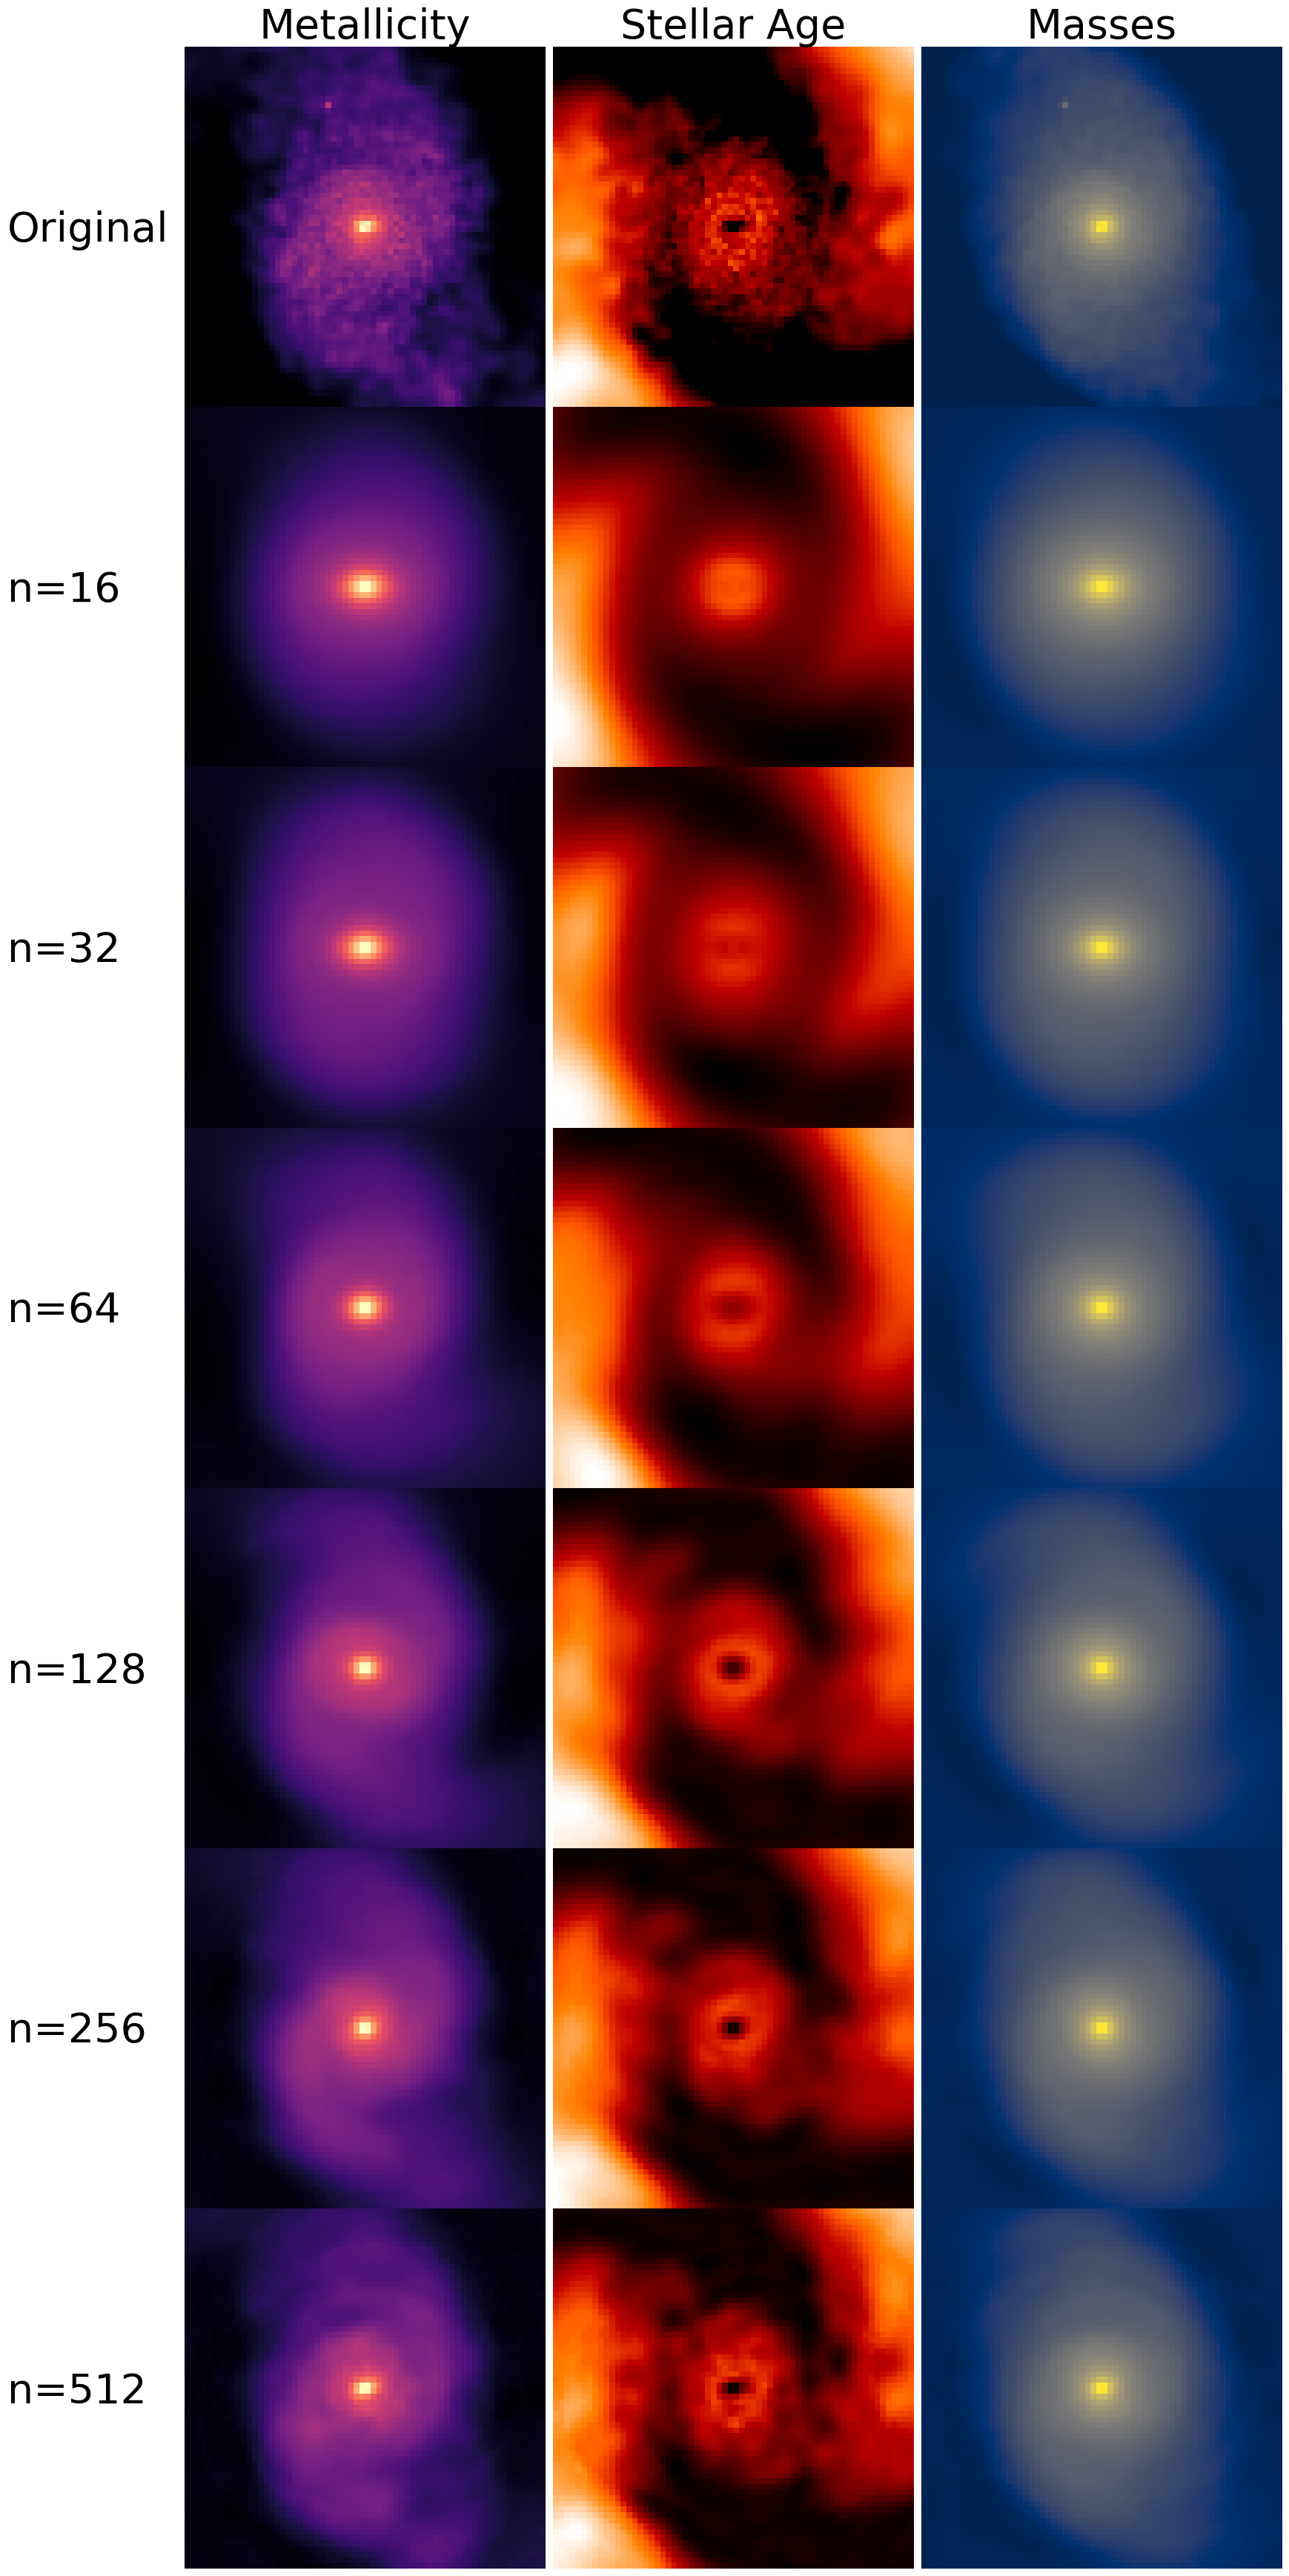

In [22]:
eigencomp = 512
reconstruct(10, col = 6,start_index = 16, plot=True, savepath=f"plots/new_reconstruction_10_{eigencomp}_comp.pdf",w_pad=0.0,h_pad=0, text_coords = (-32,32), labelsize=40)

In [24]:
def reconstruct_single(galindex, n_components, original=original, scores=scores, eigen=eigengalaxies, means=means, plot=True, cmap=None, 
                savepath = None, show = True, labelsize=20,w_pad = 0.1,h_pad = 0.1, text_coords=(-32,32), figsize=(15,15)):
    og = original[galindex]
    score = scores[galindex][:n_components]
    eig = eigen[:n_components]

    eig = eig.reshape(n_components, 3 * 64 ** 2)
    means = means.reshape(3 * 64 ** 2)
    reconstructed = np.dot(score, eig) + means
    reconstructed = reconstructed.reshape(3, 64, 64)
    residue = og - reconstructed.reshape(3, 64, 64)

    # Calculate the range for the residue images
    residue_min = np.min(residue)
    residue_max = np.max(residue)
    fields = ["Metallicity", "Stellar Age", "Masses"]
    if cmap is None:
        cmap = {"Metallicity": "magma", "Stellar Age": "gist_heat", "Masses": "cividis"}
    if plot:
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(3, 4, width_ratios=[1, 1, 1, 0.1])  # Adjust width ratios to accommodate the colorbar

        for i in range(3):
            ax1 = fig.add_subplot(gs[i, 0])
            ax1.imshow(og[i], cmap=cmap[fields[i]])
            ax1.text(*text_coords, fields[i], fontsize=labelsize, verticalalignment='center', horizontalalignment='left')
            ax1.axis("off")

            ax2 = fig.add_subplot(gs[i, 1])
            ax2.imshow(reconstructed[i], cmap=cmap[fields[i]])
          
                
            ax2.axis("off")

            ax3 = fig.add_subplot(gs[i, 2])
            im = ax3.imshow(residue[i], cmap="coolwarm", vmin=residue_min, vmax=residue_max)
            
            if i==0: 
                ax1.set_title(f"Original",fontsize=labelsize)
                ax2.set_title(f"Reconstructed", fontsize=labelsize)
                ax3.set_title(f"Residue", fontsize=labelsize)
            
            ax3.axis("off")

        # Add a single colorbar on the right side
        cax = fig.add_subplot(gs[:, 3])
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label("Residue", fontsize=labelsize)

        plt.tight_layout(w_pad=w_pad,h_pad=h_pad)
        
        if savepath is not None:
            plt.savefig(savepath, dpi=300, bbox_inches='tight')
        if show: plt.show()

    return reconstructed, og

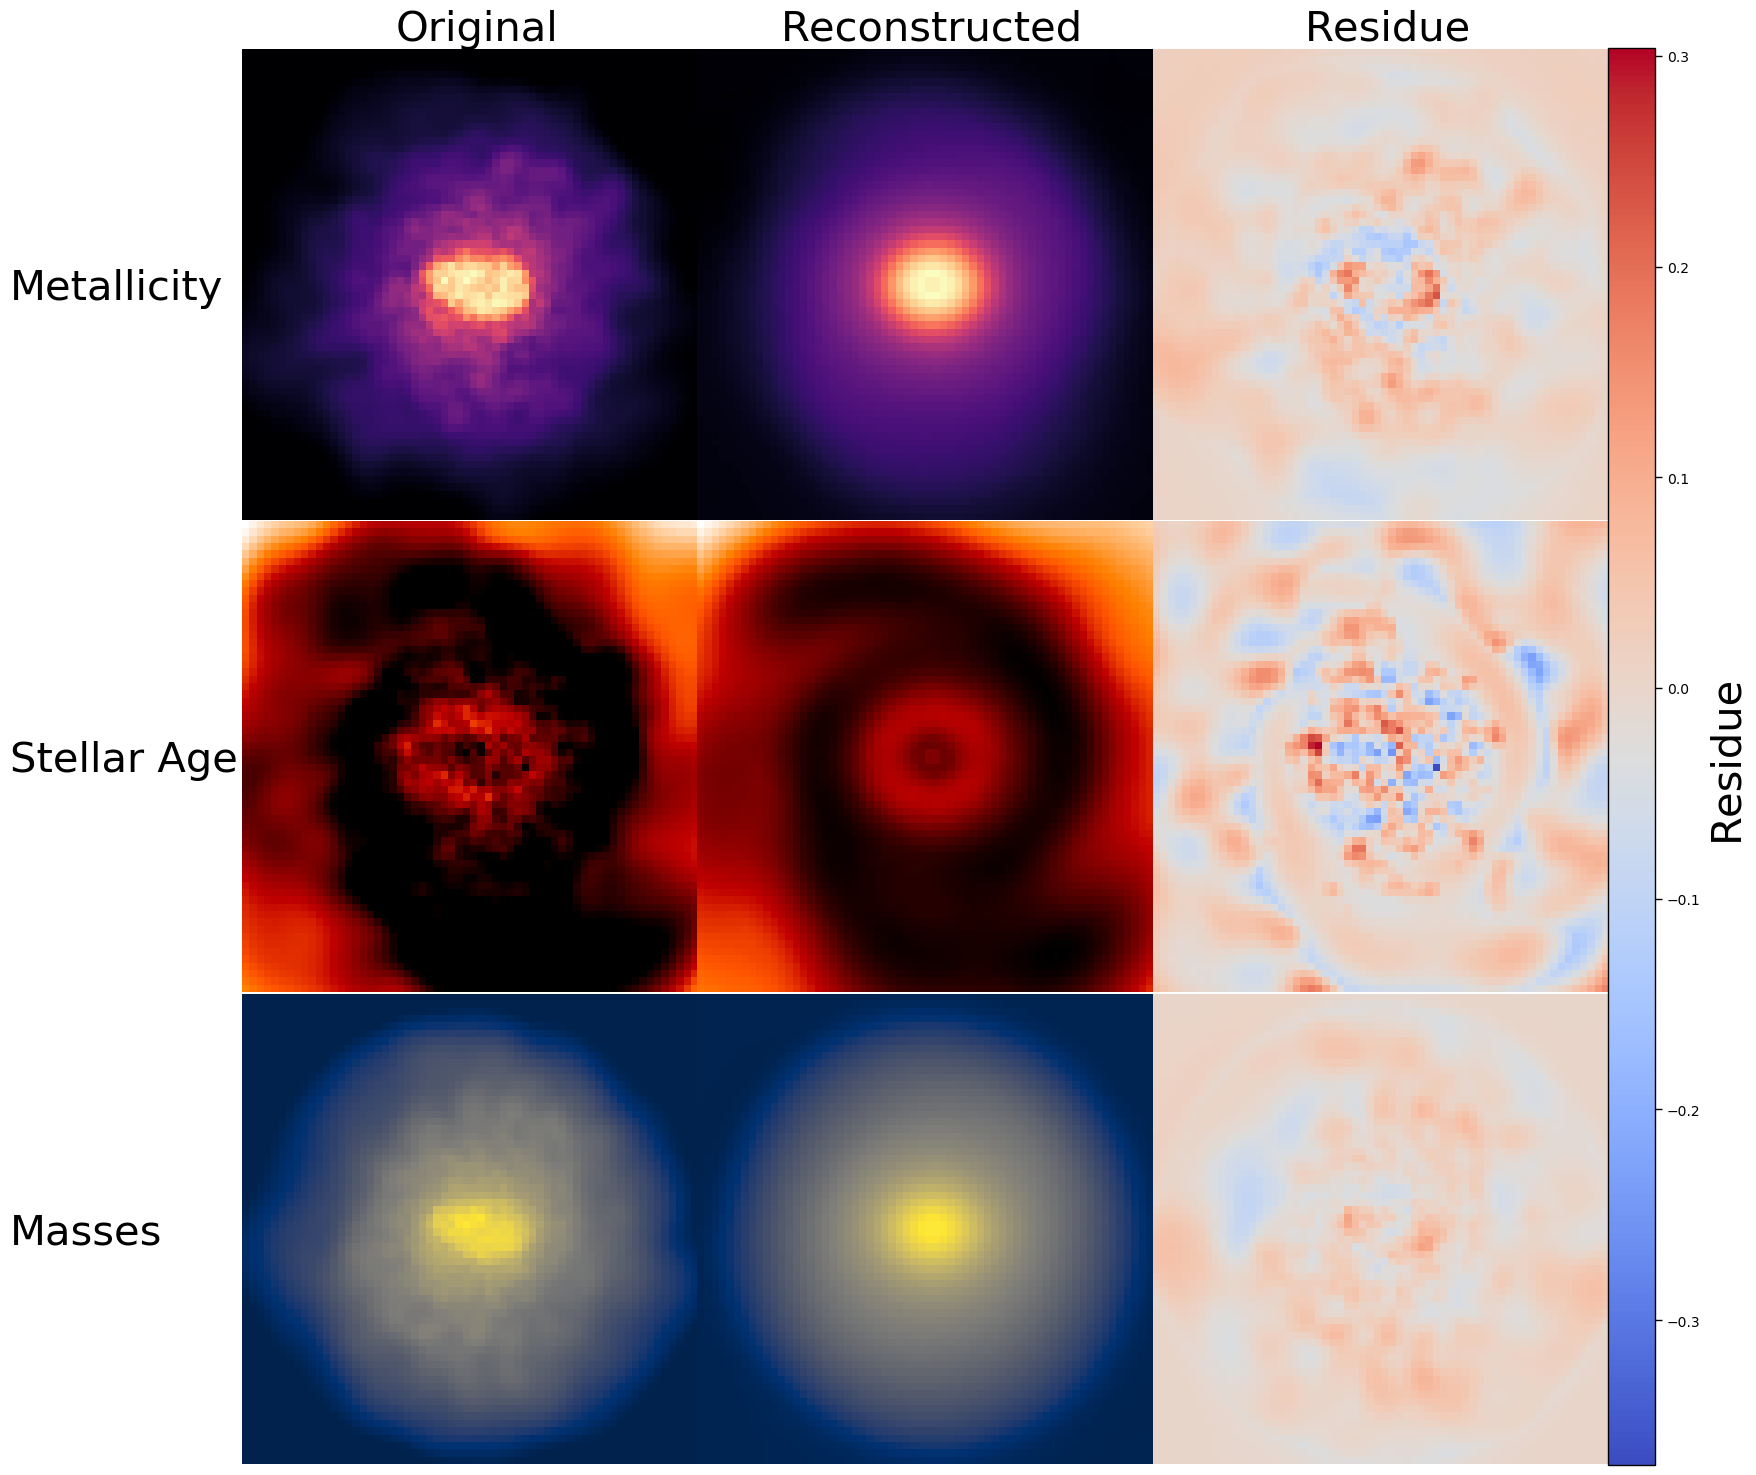

(array([[[-1.88558765e-02, -1.97393644e-02, -2.02528719e-02, ...,
          -1.64757117e-02, -1.53884610e-02, -1.43454455e-02],
         [-2.01152600e-02, -2.06978514e-02, -2.07316317e-02, ...,
          -1.70599923e-02, -1.69880996e-02, -1.52986349e-02],
         [-2.04854140e-02, -2.06468625e-02, -2.14935263e-02, ...,
          -1.77714496e-02, -1.76177621e-02, -1.67616144e-02],
         ...,
         [-6.11070457e-03, -6.54114855e-03, -7.10452492e-03, ...,
          -5.08973831e-03, -5.99575663e-03, -7.11943120e-03],
         [-5.46207441e-03, -5.93674223e-03, -6.14043751e-03, ...,
          -5.93895964e-03, -6.48090806e-03, -8.09029163e-03],
         [-4.82880449e-03, -5.16224986e-03, -4.96241273e-03, ...,
          -6.05865577e-03, -7.31344365e-03, -8.95196544e-03]],
 
        [[ 9.78563002e-01,  9.60506545e-01,  9.40849379e-01, ...,
           8.86729504e-01,  8.93504997e-01,  9.00771238e-01],
         [ 9.51194599e-01,  9.30769824e-01,  9.08378191e-01, ...,
           8.72352426

In [26]:
eigencomp = 60
galaxyindex = 24
save_path = f"plots/single_reconstruction_{galaxyindex}_{eigencomp}_comp.pdf"
#save_path = None
reconstruct_single(galaxyindex, eigencomp, plot=True, savepath=save_path,w_pad=0.0,h_pad=0.00, text_coords = (-32,32), figsize = (17,15), labelsize=30)

In [ ]:
def calc_rec_error(number_of_components):
    return np.array([sse(reconstruct(i,number_of_components,plot=False)[0],reconstruct(i,number_of_components,plot=False)[1]) for i in trange(len(original))])

In [ ]:
error_60 = np.array([sse(pca_projection[i],original[i]) for i in trange(len(original))])
plt.hist(error_60, bins=80, color="steelblue", alpha = 0.5, range = (0,0.1))
plt.grid()
plt.tick_params(bottom=True, top=True, left=True, right=True, direction='in', which='major', grid_color='black', grid_alpha=0.15)
plt.xlabel("Reconstruction error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("plots/RE_60_comp.pdf", dpi=300)

In [ ]:
# Calculate 90 percent quantile
q90 = np.quantile(error_60, 0.9)
print(q90)

In [ ]:
error_60.max()

In [ ]:
np.sqrt(len(original))

In [ ]:
len(eigengalaxies)

In [ ]:
all_err = np.array([calc_rec_error(i) for i in trange(1,len(eigengalaxies)+1)])

In [ ]:
all_err = np.array(all_err)
# Calculate 95% quantile
quantile = np.quantile(all_err, 0.9, axis=1)
#plt.figure(figsize=(5,5))
plt.plot(np.arange(1,len(eigengalaxies)+1), quantile, marker="x", color="steelblue", linestyle="dashed", linewidth=1, markersize=3,)
plt.xlabel("Eigengalaxies")
plt.ylabel("90th percentile of RE")
plt.grid()
plt.tick_params(bottom=True, top=True, left=True, right=True, direction='in', which='major', grid_color='black', grid_alpha=0.15)
plt.tight_layout()
plt.savefig("plots/90th_percentile_RE.pdf", dpi=300)

In [ ]:
np.save("rec_errors_60_comp.npy", all_err)

In [ ]:

for n in range(10,100,10):
    error = calc_rec_error(n)
    
    plt.hist(reconstruction_error, bins=100, color="steelblue", alpha = 0.5, edgecolor="black", range=(0,0.1))
plt.tick_params(bottom=True, top=True, left=True, right=True, direction='in', which='major', grid_color='black', grid_alpha=0.5)
plt.xlabel("Reconstruction error")
plt.ylabel("Frequency")
plt.tight_layout()


In [ ]:
import os
from tqdm import trange
os.makedirs("reconstructed", exist_ok=True)
for i in trange(400):
    reconstruct(10, i, plot=True, show=False, savepath=f"reconstructed/{i}.png")
    plt.close("all")



In [ ]:
# Create movie out of the 400 images
import cv2
import os
from tqdm import trange

os.makedirs("reconstructed", exist_ok=True)
img_array = []
for i in trange(400):
    img = cv2.imread(f"reconstructed/{i}.png")
    height, width, layers = img.shape
    size = (width, height)
    img_array.append(img)
    
out = cv2.VideoWriter('reconstructed.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, size)
for i in trange(len(img_array)):
    out.write(img_array[i])
    
out.release()

In [ ]:
index = 10
rec = mm.inverse_transformed_datamatrix[index].reshape(3, *mm._IMG_SHAPE)
original = mm.datamatrix[index].reshape(3, *mm._IMG_SHAPE)
        
res = np.abs(rec - original)

In [ ]:
# Calculate reconstruction error
mse = np.mean((original - rec) ** 2)
psnr = 20 * np.log10(255) - 10 * np.log10(mse)

print(f"Reconstruction MSE: {mse}")
print(f"Reconstruction PSNR: {psnr}")

In [ ]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.2)  # Adjust the bandwidth parameter as needed
kde.fit(mm.scores)
num_samples = 100  # Number of samples to generate
generated_samples = kde.sample(num_samples)

generated_data = mm.reconstruct(generated_samples[26])

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(generated_data.reshape(3, *mm._IMG_SHAPE)[0])
ax[1].imshow(generated_data.reshape(3, *mm._IMG_SHAPE)[1])
ax[2].imshow(generated_data.reshape(3, *mm._IMG_SHAPE)[2])

# Clustering

In [ ]:
from sklearn.cluster import AffinityPropagation

scores = mm.get_scores()
af = AffinityPropagation(damping=0.9).fit(scores)

In [ ]:
cluster_centers_indices = af.cluster_centers_indices_
cluster_labels = af.labels_

In [ ]:
original = mm.get_images()

In [ ]:
plt.imshow(original[cluster_centers_indices[16]][2], cmap = "gray")

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
# Create 3x3 sub plots for samples out of all 3 maps for one specific cluster

cluter_index = 11


cluster_center_galaxies = original[cluster_centers_indices[cluter_index]]
sample_indices = np.where(cluster_labels == cluter_index)[0]
sample_galaxies = original[sample_indices]

assert  len(sample_galaxies) >= 9, "Not enough samples in cluster"

fig = plt.figure()
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(3, 2),  # creates 3x3 grid of axes
                    axes_pad=0,  # pad between axes in inch.
                    )

grid[0].imshow(cluster_center_galaxies[0], cmap = "gray")
grid[0].set_title("Cluster Center")
grid[2].imshow(cluster_center_galaxies[1], cmap = "gray")
grid[4].imshow(cluster_center_galaxies[2], cmap = "gray")
subgrid = ImageGrid(fig, 122,  # similar to subplot(111)
                    nrows_ncols=(3, 3),  # creates 3x3 grid of axes
                    axes_pad=0,  # pad between axes in inch.
                    )

plt.subplots_adjust(left=-2, right=1, bottom=0.05, top=0.95, wspace=0.1, hspace=2)

j = 0
for i, ax in enumerate(subgrid):
    ax.imshow(sample_galaxies[i], cmap = "gray")
    j += 1
    

In [ ]:
# Create 3x3 sub plots for samples out of all 3 maps for one specific cluster
def create_cluster_plot(cluster_index, font_size=20):
    cluster_center_galaxies = original[cluster_centers_indices[cluster_index]]
    sample_indices = np.where(cluster_labels == cluster_index)[0]
    #Choose random samples
    #set random state
    np.random.seed(42)
    sample_indices = np.random.choice(sample_indices, 5)
    sample_galaxies = original[sample_indices]

    assert  len(sample_galaxies) >= 4, "Not enough samples in cluster"


    n_sample = 5

    fig,axes = plt.subplots(n_sample+1,3, figsize=(3*2,(n_sample+1)*2))

    axes[0,0].imshow(cluster_center_galaxies[0], cmap = "gray")
    axes[0,1].imshow(cluster_center_galaxies[1], cmap = "gray")
    axes[0,2].imshow(cluster_center_galaxies[2], cmap = "gray")

    #leave one column empty
    for i in range(2,n_sample+1):
        [axes[i,j].imshow(sample_galaxies[i-1][j], cmap = "gray") for j in range(3)]
        
        
    [axes[i,j].axis("off") for i in range(n_sample+1) for j in range(3) ]
    axes[0,1].set_title("Cluster Center", fontsize=font_size)
    axes[2,1].set_title("Cluster Samples",fontsize=font_size)
    plt.tight_layout(w_pad = 0, h_pad = 0)
    plt.savefig(f"plots/cluster_{cluster_index}.png", dpi=300, bbox_inches='tight')

In [ ]:
import matplotlib.gridspec as gridspec
# Create 3x3 sub plots for samples out of all 3 maps for one specific cluster
def create_cluster_plot(cluster_index, font_size=20):
    cluster_center_galaxies = original[cluster_centers_indices[cluster_index]]
    sample_indices = np.where(cluster_labels == cluster_index)[0]
    #Choose random samples
    #set random state
    np.random.seed(42)
    sample_indices = np.random.choice(sample_indices, 5)
    sample_galaxies = original[sample_indices]

    assert  len(sample_galaxies) >= 4, "Not enough samples in cluster"


    n_sample = 5

    fig = plt.figure()
    height_ratios = [1, 1.5] + [1] * (n_sample-1)
    gs = gridspec.GridSpec(n_sample + 1, 3, height_ratios=height_ratios)

    axes = []
    axes.append(plt.subplot(gs[0, 0]))
    axes.append(plt.subplot(gs[0, 1]))
    axes.append(plt.subplot(gs[0, 2]))
    
    axes[0,0].imshow(cluster_center_galaxies[0], cmap = "gray")
    axes[0,1].imshow(cluster_center_galaxies[1], cmap = "gray")
    axes[0,2].imshow(cluster_center_galaxies[2], cmap = "gray")

    #leave one column empty
    for i in range(1,n_sample+1):
        [axes[i,j].imshow(sample_galaxies[i-1][j], cmap = "gray") for j in range(3)]
        
        
    [axes[i,j].axis("off") for i in range(n_sample+1) for j in range(3) ]
    axes[0,1].set_title("Cluster Center", fontsize=font_size)
    axes[2,1].set_title("Cluster Samples",fontsize=font_size)
    plt.tight_layout(w_pad = 0, h_pad = 0)
    plt.savefig(f"plots/cluster_{cluster_index}.png", dpi=300, bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Create 3x3 sub plots for samples out of all 3 maps for one specific cluster
def create_cluster_plot(cluster_index, font_size=20):
    cluster_center_galaxies = original[cluster_centers_indices[cluster_index]]
    sample_indices = np.where(cluster_labels == cluster_index)[0]
    #Choose random samples
    #set random state
    np.random.seed(42)
    sample_indices = np.random.choice(sample_indices, 5)
    sample_galaxies = original[sample_indices]

    assert len(sample_galaxies) >= 4, "Not enough samples in cluster"

    n_sample = 5
    n_rows = n_sample + 1
    height_ratios = [1, 1.5] + [1] * (n_sample-1)

    fig = plt.figure()
    gs = gridspec.GridSpec(n_rows, 3, height_ratios=height_ratios)

    axes = []
    axes.append(plt.subplot(gs[0, 0]))
    axes.append(plt.subplot(gs[0, 1]))
    axes.append(plt.subplot(gs[0, 2]))

    # leave one column empty
    for i in range(1, n_sample + 1):
        axes.append(plt.subplot(gs[i, :]))

    axes[0].imshow(cluster_center_galaxies[0], cmap="gray")
    axes[1].imshow(cluster_center_galaxies[1], cmap="gray")
    axes[2].imshow(cluster_center_galaxies[2], cmap="gray")

    for i in range(3, n_sample + 3):
        axes[i].imshow(sample_galaxies[i - 3][i - 3], cmap="gray")

    [ax.axis("off") for ax in axes]

    axes[1].set_title("Cluster Center", fontsize=font_size)
    axes[3].set_title("Cluster Samples", fontsize=font_size)

    # Adjust the spacing between the second and third rows
    gs.update(hspace=0.5)

    plt.tight_layout(w_pad=0, h_pad=0)
    plt.savefig(f"plots/cluster_{cluster_index}.png", dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
create_cluster_plot(11)

In [ ]:
height_ratios=[1, 1.5] + [1] * 4

In [ ]:
height_ratios

In [ ]:
create_cluster_plot(10)

In [ ]:
create_cluster_plot(20)